In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path

# Configuration esthétique pour les graphiques
sns.set_theme(style="whitegrid")

# Définition du chemin vers les données brutes
data_dir = Path("../data/raw")

# Affichage des fichiers disponibles dans le dossier
print("Fichiers trouvés :")
for file in data_dir.iterdir():
    print(f"- {file.name}")

Fichiers trouvés :
- blackjack_simulator.csv


In [3]:
# Chargement 500 000 premières lignes pour analyse
file_name = 'blackjack_simulator.csv' 
file_path = data_dir / file_name

print("Chargement d'un échantillon des données...")



df = pd.read_csv(file_path, nrows=500000)

print(f"Dimensions du dataframe chargé : {df.shape}")
display(df.head())
df.info()

Chargement d'un échantillon des données...
Dimensions du dataframe chargé : (500000, 12)


,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 11]","[10, 4, 10]",24,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,10,"[5, 5]","[10, 8]",18,"[[5, 5, 11]]",[21],"[['H', 'S']]",-2,0,1.0
2,0,406,6,"[3, 10]","[6, 6, 10]",22,"[[3, 10]]",[13],[['S']],-2,0,1.0
3,0,401,10,"[5, 9]","[10, 8]",18,"[[5, 9, 11, 3]]",[18],"[['H', 'H', 'S']]",-1,0,0.0
4,0,395,8,"[6, 10]","[8, 2, 10]",20,"[[6, 10, 10]]",[26],[['H']],-1,0,-1.0


<class 'pandas.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shoe_id             500000 non-null  int64  
 1   cards_remaining     500000 non-null  int64  
 2   dealer_up           500000 non-null  int64  
 3   initial_hand        500000 non-null  str    
 4   dealer_final        500000 non-null  str    
 5   dealer_final_value  500000 non-null  str    
 6   player_final        500000 non-null  str    
 7   player_final_value  500000 non-null  str    
 8   actions_taken       500000 non-null  str    
 9   run_count           500000 non-null  int64  
 10  true_count          500000 non-null  int64  
 11  win                 500000 non-null  float64
dtypes: float64(1), int64(5), str(6)
memory usage: 45.8 MB


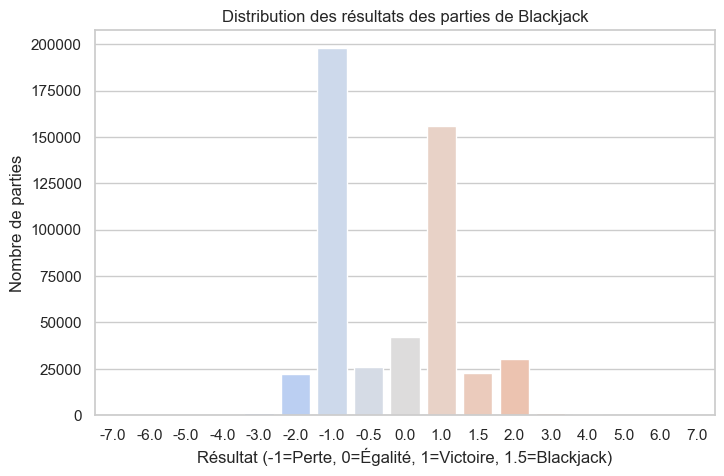

Répartition exacte en pourcentage :


win
-1.0    39.5472
 1.0    31.2210
 0.0     8.3824
 2.0     6.0850
-0.5     5.1648
 1.5     4.5520
-2.0     4.4418
 3.0     0.2454
-3.0     0.2080
 4.0     0.0676
-4.0     0.0530
 5.0     0.0150
-5.0     0.0086
 6.0     0.0040
-6.0     0.0030
 7.0     0.0010
-7.0     0.0002
Name: proportion, dtype: float64

In [6]:
# Analyse de la variable cible 'win'
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='win', hue='win', palette='coolwarm', legend=False)
plt.title("Distribution des résultats des parties de Blackjack")
plt.xlabel("Résultat (-1=Perte, 0=Égalité, 1=Victoire, 1.5=Blackjack)")
plt.ylabel("Nombre de parties")
plt.show()

# Affichage des pourcentages exacts
print("Répartition exacte en pourcentage :")
display(df['win'].value_counts(normalize=True) * 100)

In [13]:
import ast

# On considère 1 si le gain est strictement positif, 0 sinon (perte ou égalité)
df['target_win'] = (df['win'] > 0).astype(int)
# Fonction pour convertir la chaîne "[10, 11]" en vraie liste Python, puis en faire la somme
def calculate_initial_score(hand_str):
    try:
        # ast.literal_eval transforme "[10, 11]" (texte) en [10, 11] (liste)
        hand_list = ast.literal_eval(hand_str)
        return sum(hand_list)
    except:
        return 0

# Application de la fonction pour créer une nouvelle colonne numérique
df['player_initial_score'] = df['initial_hand'].apply(calculate_initial_score)

# Affichage du résultat
print("Aperçu de la transformation :")
display(df[['initial_hand', 'player_initial_score', 'dealer_up', 'target_win']].head(10))

Aperçu de la transformation :


,initial_hand,player_initial_score,dealer_up,target_win
0,"[10, 11]",21,10,1
1,"[5, 5]",10,10,1
2,"[3, 10]",13,6,1
3,"[5, 9]",14,10,0
4,"[6, 10]",16,8,0
5,"[3, 4]",7,7,0
6,"[3, 3]",6,6,1
7,"[10, 8]",18,3,0
8,"[8, 10]",18,5,1
9,"[6, 8]",14,9,1


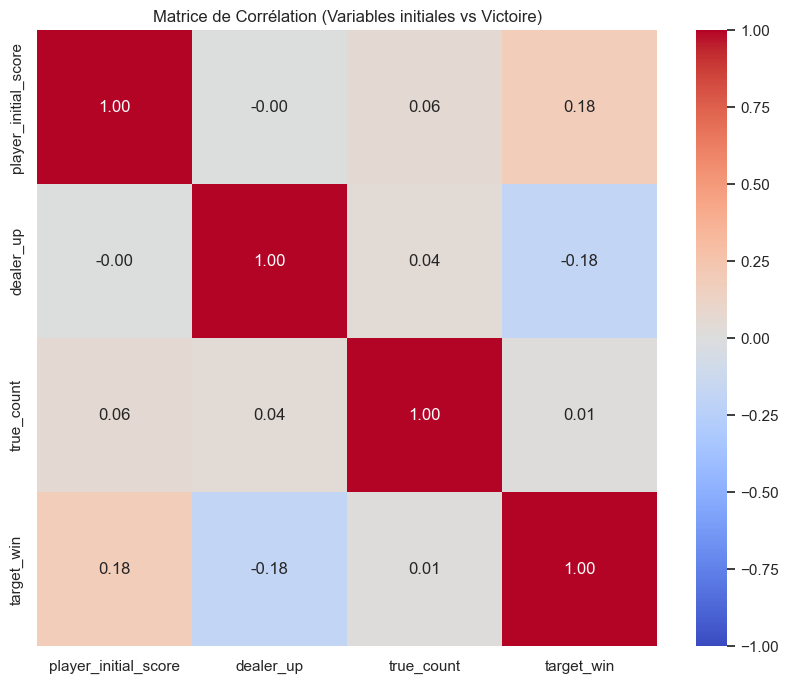

In [14]:

# Sélection des variables pertinentes pour la prédiction
features_to_correlate = ['player_initial_score', 'dealer_up', 'true_count', 'target_win']
corr_matrix = df[features_to_correlate].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matrice de Corrélation (Variables initiales vs Victoire)")
plt.show()

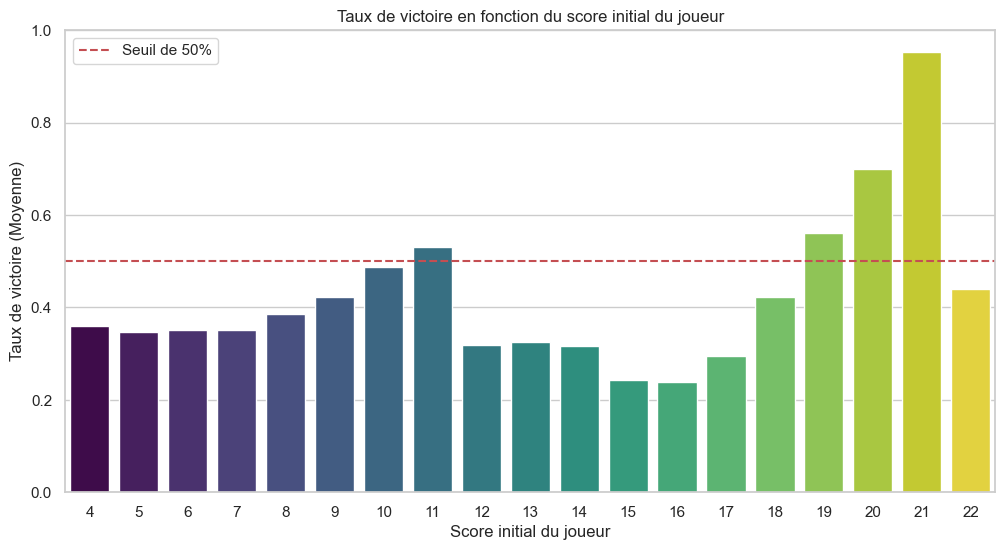

In [16]:
# Calcul du taux de victoire moyen pour chaque score initial du joueur
win_rate_by_score = df.groupby('player_initial_score')['target_win'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=win_rate_by_score.index, y=win_rate_by_score.values, hue=win_rate_by_score.index, palette="viridis", legend=False)

plt.axhline(y=0.5, color='r', linestyle='--', label='Seuil de 50%')
plt.title("Taux de victoire en fonction du score initial du joueur")
plt.xlabel("Score initial du joueur")
plt.ylabel("Taux de victoire (Moyenne)")
plt.ylim(0, 1)
plt.legend()
plt.show()